In [2]:
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, make_scorer
import pandas as pd

from setup_problem import load_problem

In [3]:
lasso_data_fname = "data/lasso_data.pickle"
x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = load_problem(lasso_data_fname)

In [4]:
# Generate features
X_train = featurize(x_train)
X_val = featurize(x_val)

In [5]:
class LassoRegression(BaseEstimator, RegressorMixin):
    """ lasso regression"""
    
    def __init__(self, l1reg=1, max_steps = 1000, weight_init = 'murphy', order = 'cyclic'):
        '''
        @weight_init =  'murphy or random'. For murphy, weights = inv(X.t X)X.t y
        @order = 'Order of coordinate iteration in Coordinate descent method'
        '''
        if l1reg < 0:
            raise ValueError('Regularization penalty should be at least 0.')
        self.l1reg = l1reg
        self.weight_init_ = weight_init
        self.order_ = order
        self.max_steps_ = max_steps
                
    def soft(self, a, lamb):
        return np.sign(a) * (np.abs(a) - lamb) * (1 * (np.abs(a) > lamb))
        
    '''
    We are using Coordinate descent method to minimize Lasso Regression objective
    Returns the learned weights, and final objective loss
    '''
    def coordinate_descent(self, init_weights,X_tr, y_tr):
        steps = 0
        del_loss = 1000000000
        prev_loss = 1000000000
        num_dim = len(init_weights)
        curr_weight = init_weights
        #While not converged
        while not(steps >= self.max_steps_ or del_loss <= 10**-8):
            
            order_vec = np.arange(0,num_dim)
            
            if self.order_!='cyclic':
                np.random.shuffle(order_vec)
            
            for j in range(num_dim):
                currdim = order_vec[j]
                X_j = X_tr[:,currdim]
                a_j = 2*(np.dot(X_j, X_j))
                c_j = 2*(np.dot(X_j, y_tr - (X_tr @ curr_weight) + curr_weight[currdim]* X_j))
                
                if a_j == 0:
                    curr_weight[currdim] = 0
                else:
                    curr_weight[currdim] = self.soft(c_j/a_j, self.l1reg/a_j)
            steps = steps + 1
            curr_loss = self.lasso_obj_(curr_weight)
            del_loss = prev_loss - curr_loss
            prev_loss = curr_loss
        return curr_weight, curr_loss            
        
    
    def fit(self, X, y=None):
        n, num_ftrs = X.shape
        # convert y to 1-dim array, in case we're given a column vector
        y = y.reshape(-1)
        
        #Function to compute lasso objective
        def lasso_obj(w):
            predictions = np.dot(X,w)
            residual = y - predictions
            empirical_risk = np.sum(residual**2)
            l1_norm = np.sum(np.abs(w))
            objective = empirical_risk + self.l1reg * l1_norm
            return objective
        
        self.lasso_obj_ = lasso_obj
        
        #initialize weights
        if self.weight_init_ == 'murphy':
            w_0 = np.linalg.inv(X.T @ X +  self.l1reg * np.eye(num_ftrs)) @ X.T @ y
        else:
            w_0 = np.zeros(num_ftrs)
        
        #Optimize by doing Coordinate descent
        self.w_ , self.minLoss_ = self.coordinate_descent(w_0, X, y)
        return self

    def predict(self, X, y=None):
        try:
            getattr(self, "w_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
        return np.dot(X, self.w_)

    def score(self, X, y):
        # Average square error
        try:
            getattr(self, "w_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
        residuals = self.predict(X) - y
        return np.dot(residuals, residuals)/len(y)

Do grid search over different L1 Regularization Parameters. Find best L1 Param and plot Validation loss vs L1 par

L1 Regularization :  1e-06 Validation loss:  0.17258981872063736 Training loss:  0.0067518509098154714
L1 Regularization :  1e-05 Validation loss:  0.17258867019556473 Training loss:  0.0067518509319723094
L1 Regularization :  0.0001 Validation loss:  0.1725778770718041 Training loss:  0.006751853116597196
L1 Regularization :  0.001 Validation loss:  0.17247069027841191 Training loss:  0.006752368909961313
L1 Regularization :  0.01 Validation loss:  0.17140950975529842 Training loss:  0.006805521951594953
L1 Regularization :  0.1 Validation loss:  0.16210502488427614 Training loss:  0.011142879785962132
L1 Regularization :  1 Validation loss:  0.12643956987110064 Training loss:  0.09195036310699073
L1 Regularization :  10 Validation loss:  0.19510534571429244 Training loss:  0.2262090961924562
L1 Regularization :  100 Validation loss:  0.8450932951785499 Training loss:  0.8837710712086175
L1 Regularization :  1000 Validation loss:  3.576552934309349 Training loss:  3.596674002813196


/home/raghavjajodia/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


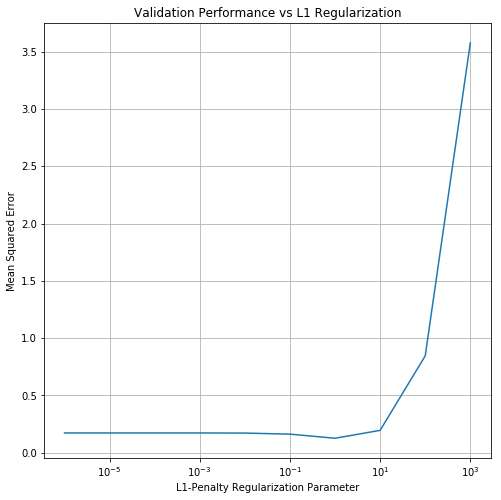

In [37]:
l1regparams = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]

valLosses = []

for l1param in l1regparams:        
    lasso_regression_estimator = LassoRegression(l1reg= l1param)
    lasso_regression_estimator.fit(X_train, y_train)
    trainLoss = lasso_regression_estimator.score(X_train, y_train)
    valLoss = lasso_regression_estimator.score(X_val, y_val)
    valLosses.append(valLoss)
    print("L1 Regularization : ",l1param,"Validation loss: ", valLoss, "Training loss: ", trainLoss)

# Plot validation performance vs regularization parameter
fig, ax = plt.subplots(figsize=(8,8))
ax.semilogx(l1regparams, valLosses)
ax.grid()
ax.set_title("Validation Performance vs L1 Regularization")
ax.set_xlabel("L1-Penalty Regularization Parameter")
ax.set_ylabel("Mean Squared Error")
fig.show()
fig.savefig('ValidationPerfVsL1Regularization.png')